In [1]:
import sys
import os
import csv
import pandas as pd
import html
import argparse
import codecs
import numpy as np
import random
import math as m
import itertools
import argparse
import re

import collections
from collections import OrderedDict
from collections import defaultdict
from itertools import chain

from matplotlib.ticker import FormatStrFormatter
#from ccdc.descriptors import CrystalDescriptors,GeometricDescriptors, MolecularDescriptors
#from ccdc._lib import MathsLib
#from ccdc.io import EntryReader
#from ccdc.io import MoleculeReader
#from ccdc.io import CrystalReader
#from ccdc.io import CrystalWriter
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import r2_score
import matplotlib
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
df = pd.read_csv('energies.txt', sep=' ', header=None, names=['file_name','energy'])
df.head()

,file_name,energy
0,NUWTIJ01_comp_1_water_xR.out,-3219.692787
1,NUWTIJ01_comp_1_water_R.out,-3219.692444
2,NUWTIJ_comp_1_water_xR.out,-3219.692148
3,NUWTIJ_comp_1_water_R.out,-3219.691259
4,NUWTIJ01_comp_1_gas_xR.out,-3219.677044


In [33]:
hard = ['RALMOG01','AMBNAC08','ACSALA15','VUSDIX04','NUWTIJ01','HXACAN08','CBMZPN16','BAPLOT03','YIGPIO03']
easy = ['RALMOG','AMBNAC07','ACSALA01','VUSDIX','NUWTIJ','HXACAN07','CBMZPN10','BAPLOT06','YIGPIO02']
del_r = [-0.03,0.03,0.051,0.055,0.056,0.063,0.068,0.136,0.151]

In [10]:
print(len(hard),len(easy),len(del_r))

9 9 9


In [62]:
file_names = list(df['file_name'])

def comp_energies(phase):
    data_dict = defaultdict(list)

    for i,ref in enumerate(easy):
        key = ref[:6]
        comp = 1
        exr = f'{ref}_comp_{comp}_{phase}_xR.out'
        er = f'{ref}_comp_{comp}_{phase}_R.out'
        hxr = f'{hard[i]}_comp_{comp}_{phase}_xR.out'
        hr = f'{hard[i]}_comp_{comp}_{phase}_R.out'


        #retrieve energies
        #easy structures
        cE_ez =  df.loc[df['file_name'] == exr, 'energy'].iloc[0]
        sE_ez =  df.loc[df['file_name'] == er, 'energy'].iloc[0]
        strain_ez = sE_ez - cE_ez

        #hard structures
        cE_hrd =  df.loc[df['file_name'] == hxr, 'energy'].iloc[0]
        sE_hrd =  df.loc[df['file_name'] == hr, 'energy'].iloc[0]
        strain_hrd = sE_hrd - cE_hrd

        ##pairwise energies
        delta_conf = cE_ez - cE_hrd
        delta_strain = strain_ez - strain_hrd
        
        data_dict[key].append(delta_conf*2625.5)
        data_dict[key].append(delta_strain*2625.5)
        data_dict[key].append(del_r[i])
        #del_r[i]

        #print(ref,'conf E=', delta_conf, 'strain_E', delta_strain)
        
    return(data_dict)

In [63]:
gas_dict = comp_energies('gas')
df1 = pd.DataFrame.from_dict(gas_dict, orient='index',
                             columns=['Del_conformational_energy(kJ/mol)',
                                      'Del_strain_energy(kJ/mol)', 'Del_rugosity'])
df1.reset_index(inplace=True)
df1 = df1.rename(columns = {'index':'Refcode'})
df1.to_csv('hard_easy_data_gas.csv',index=False,header=True)
df1.head()

,Refcode,Del_conformational_energy(kJ/mol),Del_strain_energy(kJ/mol),Del_rugosity
0,RALMOG,-3.209201,-0.507273,-0.030
1,AMBNAC,-0.001615,-0.653923,0.030
2,ACSALA,0.000375,-0.366142,0.051
3,VUSDIX,5.904382,0.295342,0.055
4,NUWTIJ,4.979576,1.536705,0.056


In [64]:
water_dict = comp_energies('water')
df1 = pd.DataFrame.from_dict(water_dict, orient='index',
                             columns=['Del_conformational_energy(kJ/mol)',
                                      'Del_strain_energy(kJ/mol)', 'Del_rugosity'])
df1.reset_index(inplace=True)
df1 = df1.rename(columns = {'index':'Refcode'})
df1.to_csv('hard_easy_data_water.csv',index=False,header=True)
df1.head()

,Refcode,Del_conformational_energy(kJ/mol),Del_strain_energy(kJ/mol),Del_rugosity
0,RALMOG,-2.752390,-2.165749,-0.030
1,AMBNAC,-0.003069,-0.584048,0.030
2,ACSALA,-0.002360,-0.233252,0.051
3,VUSDIX,4.285367,3.499161,0.055
4,NUWTIJ,1.678088,1.433103,0.056


## No need to run the above cells. Start from here

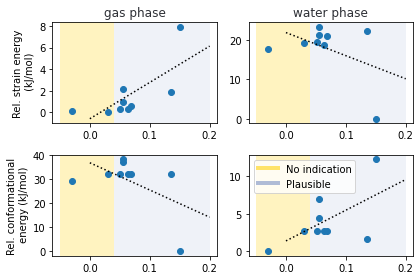

In [17]:
solvents = ['gas',  'water',]

fig, ax = plt.subplots(2,2)

for i in range(2):
    phase = solvents[i]
    df = pd.read_csv(f'hard_easy_data_{phase}.csv')
    strain_e = np.asarray(df['Del_strain_energy(kJ/mol)'])
    conf_e = np.asarray(df['Del_conformational_energy(kJ/mol)'])
    min_s = min(strain_e)
    min_c = min(conf_e)
    strain_e = strain_e-min_s
    conf_e = conf_e-min_c
    rugosity = np.asarray(df['Del_rugosity'])
    title = f'{phase} phase'
    
    ax[0][i].scatter(rugosity,strain_e )
    ax[1][i].scatter(rugosity, conf_e)
    ## linear fit
    b0, a0 = np.polyfit(rugosity, strain_e, deg=1)
    b1, a1 = np.polyfit(rugosity, conf_e, deg=1)
    xseq = np.linspace(0, 0.2, num=100)
    ax[0][i].plot(xseq, a0 + b0 * xseq, color="k",ls=':')
    ax[1][i].plot(xseq, a1 + b1 * xseq, color="k", ls=':')
    
    ax[0][i].axvspan(-0.05, 0.04, facecolor='#ffd92f',alpha=0.3,zorder=-1)
    ax[0][i].axvspan(0.04, 0.2, facecolor='#cbd5e8',alpha=0.3,zorder=-1)
    ax[1][i].axvspan(-0.05, 0.04, facecolor='#ffd92f',alpha=0.3,zorder=-1)
    ax[1][i].axvspan(0.04, 0.2, facecolor='#cbd5e8',alpha=0.3,zorder=-1)
    
    #print(f'strain - {i}',r2_score(rugosity, strain_e))
    #print(f'strain - {i}',r2_score(rugosity, conf_e))
    ax[0][i].set_title(title,c='#2e3036')
    
ax[0][0].set_ylabel('Rel. strain energy\n (kJ/mol)')
ax[1][0].set_ylabel('Rel. conformational\n energy (kJ/mol)')
custom_lines = [Line2D([0], [0], color='#ffd92f', alpha =0.7,lw=4),
                Line2D([0], [0], color='#8da0cb',alpha =0.7, lw=4)]

ax[1][1].legend(custom_lines, ['No indication', 'Plausible'],loc='upper left',facecolor='w')
    
fig.tight_layout()
fig.show()
plt.savefig(f'hard_easy_color_coded.png', dpi=300, facecolor='w')
